In [126]:
import numpy as np 
import pandas as pd 
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

In [127]:
df = pd.read_csv('../input/tehran-stock-price/output.csv').rename(columns={'Unnamed: 0':'timestamp'}).set_index('date')
df=df[["close"]]

In [128]:
test_set_size = int(np.round(0.2*df.shape[0]));
train_set_size = df.shape[0] - (test_set_size); 
train_set =df[:train_set_size]
valid_set = df[train_set_size:]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(df)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(df)))

Proportion of train_set : 0.80%
Proportion of valid_set : 0.20%


In [129]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)
n_steps = 5
train_x,train_y = split_sequence(train_set["close"],n_steps)
valid_x,valid_y = split_sequence(valid_set["close"],n_steps)

### Build CNN Forecast Model

In [130]:
class StockDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [131]:
class CNN_ForecastNet(nn.Module):
    def __init__(self,trial):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(5,trial.suggest_int('num_of_kernel_layer1', 64, 128),kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(trial.suggest_int('num_of_kernel_layer1', 64, 128),50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = x.view(-1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [132]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

TypeError: __init__() missing 1 required positional argument: 'trial'

In [ ]:
print(model)

#### Do I have to think autocorrelation when setting batch_size? 
Maybe Batch_size is important, and It is related with autocorrelation I guess.

In [133]:
train = StockDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid =  StockDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [103]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss**(0.5)
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    return train_loss
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss**(0.5)
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [72]:
epochs = 20
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/20
train_loss 4496.23828125
valid_loss 2066.025634765625
epochs 2/20
train_loss 635.3858642578125
valid_loss 317.80255126953125
epochs 3/20
train_loss 316.2846374511719
valid_loss 304.9162292480469
epochs 4/20
train_loss 307.9186096191406
valid_loss 296.6041259765625
epochs 5/20
train_loss 300.5740661621094
valid_loss 290.517333984375
epochs 6/20
train_loss 293.9757995605469
valid_loss 282.64727783203125
epochs 7/20
train_loss 286.8872375488281
valid_loss 274.55645751953125
epochs 8/20
train_loss 279.8095703125
valid_loss 267.4557800292969
epochs 9/20
train_loss 273.3001403808594
valid_loss 261.1844177246094
epochs 10/20
train_loss 267.04071044921875
valid_loss 255.15170288085938
epochs 11/20
train_loss 261.3233337402344
valid_loss 249.49295043945312
epochs 12/20
train_loss 255.8061981201172
valid_loss 243.99411010742188
epochs 13/20
train_loss 250.491943359375
valid_loss 238.390869140625
epochs 14/20
train_loss 245.11953735351562
valid_loss 233.05581665039062
epochs 15/20
tra

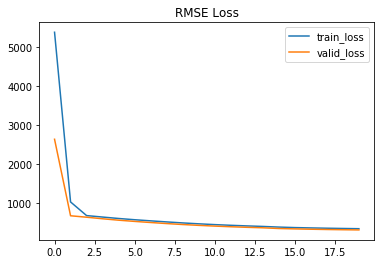

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('RMSE Loss')
plt.legend()

In [73]:
target_x , target_y = split_sequence(valid_set["close"],n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [74]:
model.eval()
prediction = []
batch_size = 1
iterations =  inputs.shape[0]

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

#### Prediction Result

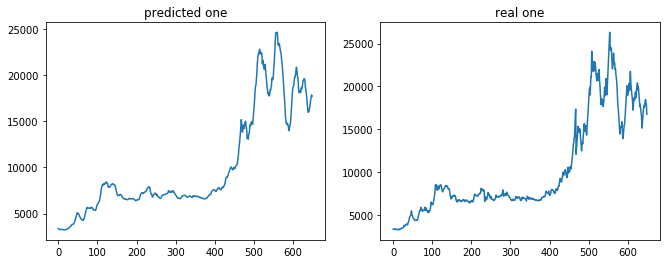

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()

Text(0, 0.5, 'Close Price')

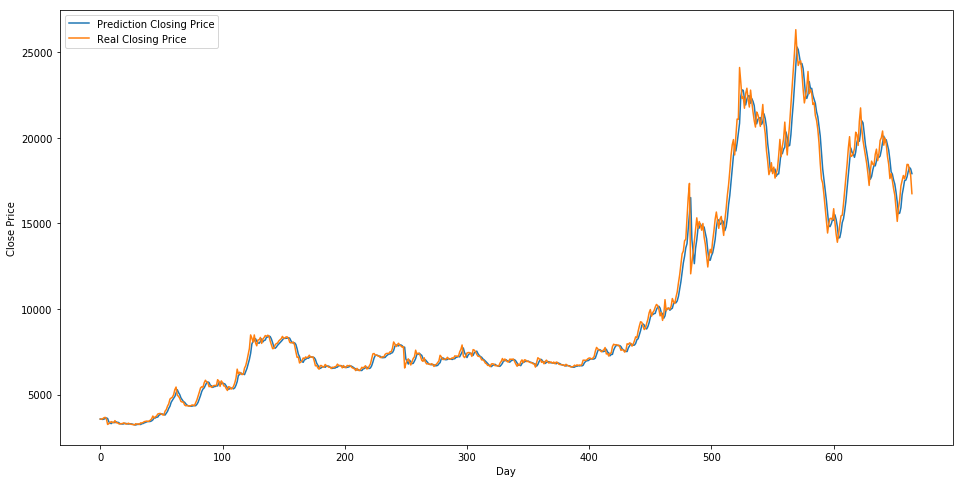

In [75]:

plt.figure(figsize=(16,8))
plt.plot(prediction,label='Prediction Closing Price')
plt.plot(target_y,label='Real Closing Price')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Close Price")

In [ ]:
import torch.optim as optim

In [104]:
def objective(trial):
    network = CNN_ForecastNet(trial)
    print(network)
    optimizer= optim.SGD(network.parameters(),
    lr=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))
    final_loss=Train()
    return(final_loss)

In [95]:
#!pip install optuna

In [119]:
import optuna
study_name = 'example-study2'  # Unique identifier of the study.
study = optuna.create_study(study_name=study_name, storage='sqlite:///example.db')
study.optimize(objective, n_trials=2)

[I 2021-02-06 19:37:40,531] A new study created with name: example-study2


CNN_ForecastNet(
  (conv1d): Conv1d(5, 83, kernel_size=(1,), stride=(1,))
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=83, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


[I 2021-02-06 19:37:47,349] Finished trial#0 resulted in value: 210.4181365966797. Current best value is 210.4181365966797 with parameters: {'learning_rate': 0.007486029942075176, 'num_of_kernel_layer1': 83}.


CNN_ForecastNet(
  (conv1d): Conv1d(5, 100, kernel_size=(1,), stride=(1,))
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


[I 2021-02-06 19:37:54,695] Finished trial#1 resulted in value: 208.7023162841797. Current best value is 208.7023162841797 with parameters: {'learning_rate': 4.745460409648784e-05, 'num_of_kernel_layer1': 100}.


In [123]:
study = optuna.create_study(study_name='example-study2', storage='sqlite:///example.db', load_if_exists=True)
df = study.trials_dataframe()

[I 2021-02-06 19:38:56,405] Using an existing study with name 'example-study2' instead of creating a new one.


In [124]:
df

number                state       value             datetime_start  \
                                                                       
0      0  TrialState.COMPLETE  210.418137 2021-02-06 19:37:40.559589   
1      1  TrialState.COMPLETE  208.702316 2021-02-06 19:37:47.353545   

           datetime_complete        params                      system_attrs  
                             learning_rate num_of_kernel_layer1      _number  
0 2021-02-06 19:37:47.321625      0.007486                   83            0  
1 2021-02-06 19:37:54.665510      0.000047                  100            1

In [125]:
print(study.best_params)  # Get best parameters for the objective function.
print('_____________________')
print(study.best_value)  # Get best objective value.
print('_____________________')
print(study.best_trial)  # Get best trial's information.
print('_____________________')
print(study.trials) # Get all trials' information.

{'learning_rate': 4.745460409648784e-05, 'num_of_kernel_layer1': 100}
_____________________
208.7023162841797
_____________________
FrozenTrial(number=1, state=TrialState.COMPLETE, value=208.7023162841797, datetime_start=datetime.datetime(2021, 2, 6, 19, 37, 47, 353545), datetime_complete=datetime.datetime(2021, 2, 6, 19, 37, 54, 665510), params={'learning_rate': 4.745460409648784e-05, 'num_of_kernel_layer1': 100}, distributions={'learning_rate': LogUniformDistribution(high=0.01, low=1e-05), 'num_of_kernel_layer1': IntUniformDistribution(high=128, low=64)}, user_attrs={}, system_attrs={'_number': 1}, intermediate_values={}, trial_id=2)
_____________________
[FrozenTrial(number=0, state=TrialState.COMPLETE, value=210.4181365966797, datetime_start=datetime.datetime(2021, 2, 6, 19, 37, 40, 559589), datetime_complete=datetime.datetime(2021, 2, 6, 19, 37, 47, 321625), params={'learning_rate': 0.007486029942075176, 'num_of_kernel_layer1': 83}, distributions={'learning_rate': LogUniformDistri